<a href="https://colab.research.google.com/github/daphnecor/Computational_neuroscience/blob/main/comp_neuro_exercises_week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Computational neuroscience week 6 [information theory]

```python
Students = {s1066862: 'Daphne Cornelisse', s4572408: 'Kyra Evers'}
```

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy.stats import truncnorm
import scipy 

## Problem 1: entropy rate of a Poisson process

Our aim is to quantify the amount of information contained in a neural signal. As neural signals contain randomness, this is a non-trivial process. We will use entropy and information theory to express [...]

### 1a) 

Let $X$ be the discrete random variable that represents the number of spikes observed over a given time period. Let $r$ be the expected value (average) of $X$ (firing rate). If $X$ follows a Poisson distribution, then the probability of observing $k$ events (spikes) over a time period $T$ is [1]:

\begin{align}
  \mathbb{P}_T(X=k) = \frac{(rT)^k}{k!} e^{-rT}
\end{align}

here, the assumption is that at each point the probability of a spike is equal to the expected value $r$ times a interval $\Delta t$. We set $\mathbb{p} = r \Delta t$ and define the probability of a spike as $p_s$ and the probability of no spike as $p_{ns}$. 

\begin{align}
  p_s &= \mathbb{p} \\
  p_{ns} &= 1 - \mathbb{p}
\end{align}

The binary entropy is then:

\begin{align}
H(\mathbb{p}) &= \color{red}{- \mathbb{p} \log_2 \mathbb{p}} - \color{blue}{(1 - \mathbb{p}) \log_2 (1 - \mathbb{p})}  \\
  & \text{if } \mathbb{p} \ll 1 \\
  &= (0) - (1 \log_2 1) \\
  &= 0
\end{align}

where $\color{red}{- \mathbb{p} \log_2 \mathbb{p}}$ is taken to be 0. When $\mathbb{p}$ tends to 0, $\log_2 \mathbb{p}$ goes to $\infty$. Linear terms grow faster than logarithmic and thus this whole term cancels out.  

we see that when $\mathbb{p} \rightarrow 0$, $H(\mathbb{p}) \rightarrow 0$ which indicates high certainty about the outcome, or in other words, the variability of the distribution is extremely low. Generally, the binary entropy is low when $\mathbb{p}$ is close to 0 or $\mathbb{p}$ is close to 1    (i.e. extremes). The binary entropy is maximised when $\mathbb{p}=\frac{1}{2}$, when both outcomes are equally likely.

The entropy typically grows linearly with the length of the period $T$. Hence, it is often preferred to state the entropy rate (total entropy/period). As the total entropy tends to 0, the entropy rate will do so as well. 

### 1b) 


In this exercise we are asked to determine the entropy per interspike interval and convert it to an entropy rate.

<!-- The probability of an interspike interval falling in the range between $(\tau, \tau + \Delta \tau)$ is given by the ISI probability density $p[\tau]\Delta \tau$. -->

In the general case, the entropy rate $\dot H$ for a spike train with an ISI distribution $\mathbb{p}(t)$ and average firing rate $r$ is computed as [3]:

\begin{align}
  \dot H & \leq - r \int_0^{\infty} \mathbb{p}(t) \log_2 \mathbb{p}((t)\Delta t) dt 
\end{align}

which indicates an upper bound for the entropy rate. In practice, the entropy rate may be lower due to correlations in the data. However, given was that the spike train follows a homogeneous Poisson Process with firing rate $r$:

\begin{align}
  \mathbb{p}(t) = r e^{-rt}
\end{align}

so we assume that the interspikes are statistically independent. The inequality thus becomes an equality. Integration yields

\begin{align}
\dot H &= - r \int_0^{\infty} \mathbb{p}(t) \log_2 \mathbb{p}((t)\Delta t) dt \\
        &= - r \int_0^{\infty} \color{blue}{(r e^{-rt})} \log_2 \color{blue}{(r e^{-rt})} \Delta t dt \\
        & * \text{u subs & integration by parts } *
\end{align}


This results in the **Poisson entropy rate**

\begin{align}
\dot H = \frac{r}{\log_2} (1 - \log_2 (r \Delta t)) 
\end{align}

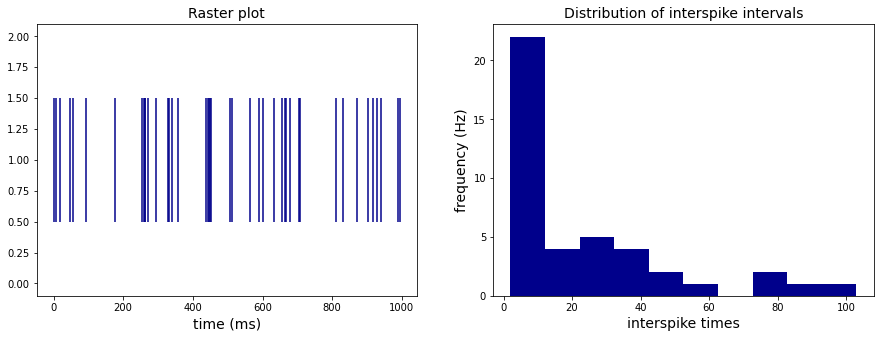

In [ ]:
#@title Distribution of interspike intervals

r = 50 
dt = 0.001 
t = 1.00
times = np.arange(0, t+dt, dt)
pt = np.random.rand(len(times)) 
spikes = lambda r, dt: r * dt 

spike_train = (np.repeat(spikes(r, dt), len(times)) > pt).astype('float64')
spike_times = np.array(np.where(spike_train == 1)) 
spike_intervals = spike_times[0, 1:spike_times.shape[1]] - spike_times[0, 0:spike_times.shape[1] - 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_title('Raster plot', fontsize=14)
ax1.eventplot(spike_times, colors='darkblue')
ax1.set_xlabel('time (ms)', fontsize=14)

ax2.hist(spike_intervals, color='darkblue')
ax2.set_title('Distribution of interspike intervals', fontsize=14)
ax2.set_xlabel('interspike times', fontsize=14)
ax2.set_ylabel('frequency (Hz)', fontsize=14);

## Problem 2: bias in entropy and Strong's method


### 2a)

Consider the stimulus response relationship $\mathbb{p}(r|s)$ with 3 possible stimuli and 4 possible responses, resulting in a $4 \times 3$ matrix that encodes the probabilities. We assume the prior is given as $\mathbb{p} = \left[ \frac{1}{3}, \frac{1}{3}, \frac{1}{3} \right]$.

\begin{align}
\mathbb{p}(r) &= \sum_s \mathbb{p}(r|s) \mathbb{p}(s) \\
              &= \mathbb{p}(\mathbf{r} | \mathbf{s}) \cdot \mathbb{p}(\mathbf{s}) \\
              &=  \begin{pmatrix} \frac{1}{3} \\ \frac{1}{3} \\ \frac{1}{6} \\ \frac{1}{6} \end{pmatrix}
\end{align}

The response entropy is then

\begin{align}
\color{darkred}{H(R)} &= - \sum_{r} \mathbb{p}(r) \log_2 \mathbb{p}(r) \\
&= \left[ 2 \left( \frac{1}{3} \log_2 \frac{1}{3} \right) \right] + \left[ 2 \left( \frac{1}{6} \log_2 \frac{1}{6} \right) \right] \\
&= - \frac{2}{3}\log _2 3 - \frac{1}{3}\log _2 6 \\
&= - \left( \log_2 3^{\frac{2}{3}} +   \log_2 6^{\frac{1}{3}} \right) \\
&= - \log_2 (3^{\frac{2}{3}} \cdot 6^{\frac{1}{3}}) \\
&= - \log_2 (3 \cdot 2^{\frac{1}{3}}) \\
& \approx 1.918
\end{align}

and the noise entropy is 

\begin{align}
\color{darkblue}{H(R|S)} &= \sum_{r,s} \mathbb{p}(s) \mathbb{p}(r | s) \log_2 \mathbb{p}(r | s) \\
  &= \mathbb{p}(\bf{s}) \mathbb{p}(r | s) \log_2 \mathbb{p}(r | s) \\
  &  \approx 1.295
\end{align}

subsequently, the exact mutual information $I(R|S)$ is:

\begin{align}
I(R|S) &= \color{darkred}{H(R)} - \color{darkblue}{H(R|S)} \\
       &= \color{darkred}{1.918} - \color{darkblue}{1.295} \\
       &= 0.623 \\
\end{align}

In [ ]:
P_rs = np.array([[2/3, 5/18, 1/18], 
                 [5/18, 2/3, 1/18], 
                 [1/36, 1/36, 4/9], 
                 [1/36, 1/36, 4/9]])
P_s = np.array([1/3, 1/3, 1/3])

P_r = P_rs @ P_s

HR_exact = - np.sum(np.multiply(P_r, np.log2(P_r, where=P_r > 0))) 
HRS_exact = - np.dot(P_s, np.sum(np.multiply(P_rs, np.log2(P_rs)), axis = 0))

### 2b) 

We have 3 stimuli and 4 possible responses. For each generated response of a stimulus
$$
s_i \in \{s_1, s_2, s_3 \}
$$
the corresponding column in $\mathbb{p}(r|s)$ is taken and assigned to the response
$$
r_k \in \{r_1, r_2, r_3, r_4 \}
$$
with the highest probability. We generate $N_s$ pairs for each stimulus of $(s_i, r_k)$. As there are 3 stimuli this leads to a total of $N = 3 N_s$ responses.

In [ ]:
def generate_rs_pairs(P_rs, Ns=1000):
  pairs = np.zeros([Ns, P_rs.shape[1]])
  
  for s in range(P_rs.shape[1]): 
    for r in range(Ns): 
      pairs[r, s] = np.random.choice([1,2,3,4], p=P_rs[:, s])
  return pairs

In [ ]:
P_rs = np.array([[2/3, 5/18, 1/18], 
                 [5/18, 2/3, 1/18], 
                 [1/36, 1/36, 4/9], 
                 [1/36, 1/36, 4/9]])
P_s = np.array([1/3, 1/3, 1/3])

RS_pairs = generate_rs_pairs(P_rs, Ns=1000)

In [ ]:
RS_pairs[:10]

array([[1., 2., 4.],
       [1., 1., 3.],
       [2., 1., 3.],
       [2., 2., 4.],
       [1., 1., 4.],
       [1., 1., 4.],
       [2., 2., 4.],
       [1., 2., 3.],
       [1., 2., 4.],
       [1., 2., 1.]])

### 2c)

We want to naively estimate $\mathbb{p}(r|s)$ based on $N=1000$ samples using that:

\begin{align}
\mathbb{p}(r_i | s_i) = \frac{\text{number of observed } r_i}{N_s}
\end{align}

In [ ]:
'''
Naively estimate P(r|s) by counting the occurences of each response (1,2,3,4) for each stimulus. 
'''
num_P_rs = np.zeros((P_rs.shape[0], P_rs.shape[1]))

for resp in [1, 2, 3, 4]:
  num_P_rs[resp-1, :] = np.count_nonzero(RS_pairs == resp, axis=0) / 1000

print(f'numerical P(r|s):\n {num_P_rs} \n')
print(f'true P(r|s):\n {P_rs}')

numerical P(r|s):
 [[0.645 0.264 0.069]
 [0.296 0.671 0.056]
 [0.021 0.045 0.428]
 [0.038 0.02  0.447]] 

true P(r|s):
 [[0.66666667 0.27777778 0.05555556]
 [0.27777778 0.66666667 0.05555556]
 [0.02777778 0.02777778 0.44444444]
 [0.02777778 0.02777778 0.44444444]]


### 2d) 

Here, we estimate the response entropy $H(R)$ and noise entropy $H(R|S)$ as a function of N. Strong et al., (1998) showed that the entropy estimate can be rewritten as a power of N as:

\begin{align}
  H(N) = H_{\infty} + \frac{a}{N} + \frac{b}{N^2}
\end{align}

where $H(R)$ is the estimate we currently have and $H_{\infty}$ is the entropy we want to find by fitting a polynomial curve through our estimate. 


In [ ]:
def estimator(iters, P_rs, P_s, Ns_range):
  '''estimates the response entropy H(R) and noise entropy H(R|S) based on a number of samples. 
  '''
  H_R = np.zeros((iters, len(Ns_range)))
  H_RS = np.zeros((iters,len(Ns_range)))
  
  for i in range(iters): 
    for v in range(len(Ns_range)):
      rs_pairs = generate_rs_pairs(P_rs, Ns=Ns_range[v])
      num_P_rs = np.zeros((P_rs.shape[0], P_rs.shape[1]))

      for resp in [1, 2, 3, 4]:
        num_P_rs[resp-1, :] = np.count_nonzero(RS_pairs == resp, axis=0) / Ns_range[v]

        P_r = P_rs @ P_s

        HR_iv = - P_r @ np.log2(P_r, where=P_r > 0)
        H_R[i, v] = HR_iv 
      
      HRS_i = - P_s @ (np.sum(np.multiply(num_P_rs, np.log2(P_rs, where=P_rs>0)), axis=0))
      H_RS[i, v] = HRS_i
      
  return H_R, H_RS

In [ ]:
Ns_range = (np.round(10**(np.arange(1, 4+.5, .25)) / 3)).astype(int)

H_R, H_RS = estimator(10, P_rs, P_s, Ns_range)

In [ ]:
'''
Fit curve through mean H(R) and H(R|S) as a function of N
'''

H_inf = lambda N, y0, a, b: y0 + (a/N) + (b/N) 

strong_HR, _ = scipy.optimize.curve_fit(H_inf, xdata=Ns_range, ydata=np.mean(H_R, axis=0))
intercept_HR, _, _ = strong_HR

strong_HRS, _ = scipy.optimize.curve_fit(H_inf, xdata=Ns_range, ydata=np.mean(H_RS, axis=0))
intercept_HRS, _, _ = strong_HRS

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In the top row, $N$ is plotted on a $log_{10}$ scale. In the bottom row, $\frac{1}{N}$ is plotted. Note that extrapolating Strong's estimate to $\frac{1}{N}$, meaning that we take the intercept $H_{\infty}$ of the fitted polynomial curve, it is very close to the exact entropy for both $H(R)$ and $H(R|S)$. Consequently, the extrapolated mutual information is very close to the exact mutual information. Our numnerical estimate converges to the exact entropy for $N \approx 10^{2.5}$.

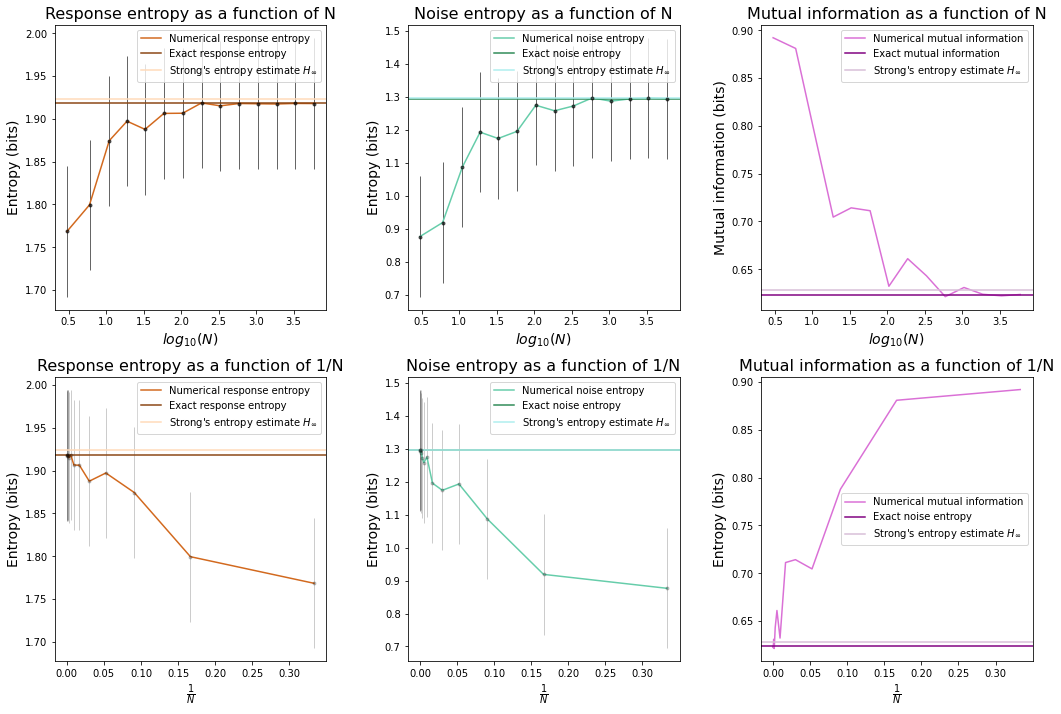

The size of the bias for $N=30$ samples:

In [ ]:
N = 30
Ns = int(N/3)

rs_pairs = generate_rs_pairs(P_rs, Ns) # make pairs
num_P_rs = np.zeros((P_rs.shape[0], P_rs.shape[1]))

for resp in [1, 2, 3, 4]:
  num_P_rs[resp-1, :] = np.count_nonzero(rs_pairs == resp, axis=0) / Ns 

P_r = np.dot(num_P_rs, P_s)

HR_estimate_30 = - np.dot(P_r, np.log2(P_r, where=P_r > 0))
HRS_estimate_30 = - np.dot(P_s, np.sum(np.multiply(P_rs, np.log2(num_P_rs, where=num_P_rs > 0)), axis = 0))

print(f'numerical P(r|s):\n {num_P_rs} \n')
print(f'true P(r|s):\n {P_rs}')

print(f'\n For N = {N} samples, the response entropy is {round(HR_estimate_30,3)} and the noise entropy is {round(HRS_estimate_30,3)} \n')
print(f'The bias in H(R) is {round(HR_exact - HR_estimate_30,3)} and the bias in H(R|S) is {round(HRS_exact - HRS_estimate_30,3)} \n')

numerical P(r|s):
 [[0.9 0.4 0. ]
 [0.1 0.6 0.1]
 [0.  0.  0.4]
 [0.  0.  0.5]] 

true P(r|s):
 [[0.66666667 0.27777778 0.05555556]
 [0.27777778 0.66666667 0.05555556]
 [0.02777778 0.02777778 0.44444444]
 [0.02777778 0.02777778 0.44444444]]

 For N = 30 samples, the response entropy is 1.85 and the noise entropy is 1.031 

The bias in H(R) is 0.069 and the bias in H(R|S) is 0.264 



## Problem 3: bias in entropy and shuffling

Consider a population of 2 neurons $n_a, n_b$ that each can generate 3 different responses. We have $3^2 = 9$ different responses and 2 stimuli that occur with equal probability. The response probabilities are represented in two matrices in the form:

\begin{align}
  \color{grey}{\mathbb{p}(r_A, r_B | s_i) = 
  \begin{pmatrix}
  a_1 b_1 & a_1 b_2 & a_1 b_3 \\
  a_2 b_1 & a_2 b_2 & a_2 b_3 \\
  a_3 b_1 & a_3 b_2 & a_3 b_3
  \end{pmatrix}}
\end{align}

where each element $a_i b_i$ represents the likelihood of the simultaneous response of the two neurons (adding all probabilities in the matrix should add up to 1). For stimulus $s_1$ and $s_2$ the probabilities are distributed as follows:

\begin{align}
\mathbb{p}(r_A, r_B | \color{blue}{s_1}) = 
\color{blue}{
\begin{pmatrix}
\frac{4}{18} & \frac{3}{18} & \frac{1}{18}\\
\frac{3}{18} & \frac{4}{18} & \frac{1}{18}\\
\frac{1}{18} & 0 & \frac{1}{18}\\
\end{pmatrix}}
\end{align}

\begin{align}
\mathbb{p}(r_A, r_B | \color{red}{s_2}) = 
\color{red}{
\begin{pmatrix}
\frac{1}{18} & \frac{7}{144} & \frac{1}{144}\\
\frac{1}{18} & \frac{4}{18}  & \frac{3}{18}\\
\frac{1}{18} & \frac{3}{18}  & \frac{4}{18}\\
\end{pmatrix}}
\end{align}


### 3a) 


In [ ]:
'''
(0) Represent P(ra, rb | si) and prior as ndarray
'''
P_rab_s1 = np.array([[4/18, 3/18, 1/18],
                    [3/18, 4/18, 1/18],
                    [1/18, 0.0, 1/18]])

P_rab_s2 = np.array([[1/18, 7/144, 1/144],
                    [1/18, 4/18, 3/18],
                    [1/18, 3/18, 4/18]])

P_s = np.array([[1/2, 1/2]])

In [ ]:
'''
(1) Compute P(r) for all 9 * 2 responses

(2) Compute H(R), the response entropy
'''
P_r = P_rab_s1 * P_s[0][0] + P_rab_s2 * P_s[0][1] 

H_R_exact = - np.sum(np.multiply(P_r, np.log2(P_r, where=P_r > 0))) 

In [ ]:
'''
(3) Compute H(R|S), the noise entropy

(4) Mutual information I(R|S) = H(R) - H(R|S)
'''
sum_s1 = np.sum(np.multiply(P_rab_s1, np.log2(P_rab_s1, where=P_rab_s1 > 0))) # sum over responses
sum_s2 = np.sum(np.multiply(P_rab_s2, np.log2(P_rab_s2, where=P_rab_s2 > 0)))

H_RS_exact = - float(np.dot(P_s, np.array([sum_s1, sum_s2])))
I_RS = round(H_R_exact - H_RS_exact,3)

print(f'The exact response entropy is: {round(H_R_exact,3)} and the exact noise entropy is: {round(H_RS_exact,3)}')
print(f'Thus, the exact mutual information is: {I_RS}')

The exact response entropy is: 3.011 and the exact noise entropy is: 2.768
Thus, the exact mutual information is: 0.243


### 3b) 

We determine the bias in the entropy estimate for $N=100$ and 1000 samples.

In [ ]:
def generate_pairs(P_rs, Ns):
  ''' Generate a number of response-stimulus pairs for each response in Ns
  '''
  pairs = np.zeros(Ns)
  for r in range(Ns): 
    pairs[r] = np.random.choice(np.arange(1, 10), p=np.ndarray.flatten(P_rs))
  return pairs

In [ ]:
'''
(1) Generate stimulus response pairs 

(2) Calculate numerical estimates
'''
Ns = 50
counts_s1 = []
counts_s2 = []

rs_pairs = np.zeros((Ns, 2))
rs_pairs[:, 0] = generate_pairs(P_rab_s1, Ns)
rs_pairs[:, 1] = generate_pairs(P_rab_s2, Ns)

for res in np.arange(1, 10): # for each response in (1 -> 9)
  # count occurrence
  num_P_rab_s1 = np.count_nonzero(rs_pairs[:,0] == res) / Ns
  num_P_rab_s2 = np.count_nonzero(rs_pairs[:,1] == res) / Ns
  counts_s1.append(num_P_rab_s1)
  counts_s2.append(num_P_rab_s2)

num_Pr_s1 = np.array(counts_s1).reshape(3,3)
num_Pr_s2 = np.array(counts_s2).reshape(3,3)

print(f'Exact P(ra, rb|s1): \n {P_rab_s1} \n')
print(f'Numerical P(ra, rb|s1): \n {num_Pr_s1} \n')


print(f'Exact P(ra, rb|s2): \n {P_rab_s2} \n')
print(f'Numerical P(ra, rb|s2): \n {num_Pr_s2} \n')

Exact P(ra, rb|s1): 
 [[0.22222222 0.16666667 0.05555556]
 [0.16666667 0.22222222 0.05555556]
 [0.05555556 0.         0.05555556]] 

Numerical P(ra, rb|s1): 
 [[0.26 0.22 0.06]
 [0.14 0.2  0.04]
 [0.04 0.   0.04]] 

Exact P(ra, rb|s2): 
 [[0.05555556 0.04861111 0.00694444]
 [0.05555556 0.22222222 0.16666667]
 [0.05555556 0.16666667 0.22222222]] 

Numerical P(ra, rb|s2): 
 [[0.06 0.   0.02]
 [0.04 0.26 0.18]
 [0.06 0.22 0.16]] 



In [ ]:
'''
Compute H(R) and H(R|S) from these estimates (num => numerical)
'''

P_r_num = np.dot(num_Pr_s1, P_s[0][0]) + np.dot(num_Pr_s2, P_s[0][1]) 

H_R_num = - np.sum(np.multiply(P_r_num, np.log2(P_r_num, where=P_r_num>0)))

s1_inner = np.sum(np.multiply(num_Pr_s1, np.log2(num_Pr_s1, where=num_Pr_s1 > 0)))
s2_inner = np.sum(np.multiply(num_Pr_s2, np.log2(num_Pr_s2, where=num_Pr_s2 > 0)))

H_RS_num = - float(np.dot(P_s, np.array([s1_inner, s2_inner])))

num_I_RS = H_R_num - H_RS_num


print(f'\n For N = {Ns*2} samples, numerical H(R) is: {round(H_R_num, 3)} while the exact H(R) is: {round(HR_exact, 3)} --> bias: {round(HR_exact - H_R_num,3)}\n')
print(f'\n The numerical H(R|S) is: {round(H_RS_num, 3)} while the exact H(R|S) is: {round(H_RS_exact, 3)} --> bias: {round(H_RS_exact - H_RS_num,3)} \n')
print(f'\n The bias in mutual information I(R|S) is: {round(I_RS - num_I_RS, 3)}')


 For N = 100 samples, numerical H(R) is: 3.008 while the exact H(R) is: 1.918 --> bias: -1.09


 The numerical H(R|S) is: 2.644 while the exact H(R|S) is: 2.768 --> bias: 0.124 


 The bias in mutual information I(R|S) is: -0.121


## 3c & d)

\begin{align}
H(N) = H_{\text{naive}} - (H_{\text{shuffle}} - H_{\text{ind}}) 
\end{align}

We implement the shuffling procedure and report the results for a given trial:

Given

\begin{align}
\mathbb{p}(r_A, r_B | \color{blue}{s_1}) = 
\color{blue}{
\begin{pmatrix}
\frac{4}{18} & \frac{3}{18} & \frac{1}{18}\\
\frac{3}{18} & \frac{4}{18} & \frac{1}{18}\\
\frac{1}{18} & 0 & \frac{1}{18}\\
\end{pmatrix}}
\end{align}
and
\begin{align}
\mathbb{p}(r_A, r_B | \color{red}{s_2}) = 
\color{red}{
\begin{pmatrix}
\frac{1}{18} & \frac{7}{144} & \frac{1}{144}\\
\frac{1}{18} & \frac{4}{18}  & \frac{3}{18}\\
\frac{1}{18} & \frac{3}{18}  & \frac{4}{18}\\
\end{pmatrix}}
\end{align}

we obtain the exact $\mathbb{p}(r)$

\begin{align}
\mathbb{p}(r)_{\text{exact}} = \begin{pmatrix}
  0.22  & 0.167 & 0.056 \\
  0.167 & 0.22  & 0.056 \\
  0.056 & 0.    & 0.056
  \end{pmatrix}
\end{align}

and the numerical $\mathbb{p}(r)$

\begin{align}
\mathbb{p}(r)_{\text{numerical}} = \begin{pmatrix}
  0.24 & 0.1   & 0.01 \\
  0.18 & 0.2   & 0.08 \\
  0.06 & 0.04  & 0.0
  \end{pmatrix}
\end{align}



The exact entropy values are:

\begin{align}
  H(R) = 3.011 \qquad \text{ and  } \qquad H(R|S) = 2.768 \rightarrow I(R|S) = 0.243 \\ 
\end{align}

---

The `naive` simulation results with `N=100` are:
\begin{align}
  H(R) = 3.048 \qquad \text{ and  } \qquad H(R|S) = 2.701 
\end{align}
The bias in $H(R)$ is 0.038 and the bias in $H(R|S)$ is -0.067 which means the bias in $I(R|S)$ (mutual information) is 0.105.

---

The `shuffled` simulation results with `N=100` are:
\begin{align}
  H(R) = 3.116 \qquad \text{ and  } \qquad H(R|S) = 2.811 \\
\end{align}

Moreover, 
\begin{align}
  H(R | S)_{ind} = 0.989
\end{align}

Thus, the estimated noise entropy with minimized bias is 0.879 and the `shuffled` information estimator is 2.169.

We conclude that the shuffling procedure has minimised the bias with some amount, compared to the naive estimator.

## Notes on entropy and information theory




---

> the **Shannon information** content of an outcome $x$ is [2]:
\begin{align}
    h(x) = \log_2 \frac{1}{\mathbb{p}(x)}
\end{align}

---

The *entropy* $H(X)$ of an ensemble $X$ is the *average* Shannon information content of an outcome. In the context of neurons it may be the amount of surprise associated with a stimulus, which is stochastic. There are multiple different versions of entropy such as the Gibbs and Boltzmann entropy:

---

> The **Gibbs entropy** $H$ for a continuous process is defined as 
\begin{align}
  H(x) = - k \int_x \mathbb{p}(x) \log_2 \mathbb{p}(x) dx
\end{align}
> or in the discrete case
\begin{align}
  H(x) = - \sum_i \mathbb{p}(x_i) \log_2 \mathbb{p}(x_i)
\end{align}
where we use $\log_2(.)$ to get the result in bits. Entropy is a measure of how much is unknown about the system. In statistical terms, it indicates the variability of the distribution.

---

---

> **Boltzmann entropy**
\begin{align}
  H(X) = k_b \log W
\end{align}
where $W$ is the volume of a macrostate

---
Consider the 1D example of two distributions below, when $\sigma$ is small, the distribution is dense, which is the same as saying that the variance is low. Here:
- The density with $\color{red}{\sigma = 1}$ has a *low entropy*, which means we know a lot about the system.

- The density with $\color{blue}{\sigma = 3}$ has a *high entropy*, which means we don't know a lot about the system (it is spread out). 

Thus, we can intuitively understand the following properties of entropy:
- the entropy is maximised if $\mathbb{p}$ is uniform
- the entropy only depends on the variance $\sigma$ (it is independent of the mean)
- if $\sigma \rightarrow 0$ the density approaches a $\delta$ function and hence entropy (uncertainty) decreases.

---
> The **Entropy rate** is the number of bits per second: (total entropy) / (time period).

---


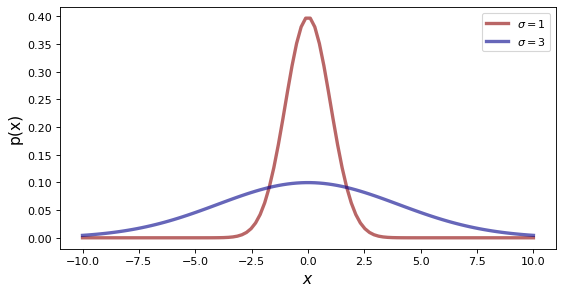

---

> The **mutual information** $I$ is the difference between the response and the noise entropy, it measures how much the uncertainty is reduced:
\begin{align}
I(R | S) &= \color{darkred}{H(R)} - \color{darkblue}{H(R|S)} \\
         &=  \color{darkred}{-\sum_{r,s} \mathbb{p}(r | s) \mathbb{p}(s) \log_2 \mathbb{p}(r)} + \color{darkblue}{\sum_{r,s} \mathbb{p}(s) \mathbb{p}(r | s) \log_2 \mathbb{p}(r | s)} \\
  &=  \color{darkred}{-\sum_{r} \mathbb{p}(r) \log_2 \mathbb{p}(r)} + \color{darkblue}{\sum_{r,s} \mathbb{p}(s) \mathbb{p}(r | s) \log_2 \mathbb{p}(r | s)} \\
  &= \sum_{s} \mathbb{p}(s) \sum_{r} \mathbb{p}(r | s) \log_2 \frac{ \mathbb{p}(r|s)}{\mathbb{p}(r)}
\end{align}

---

where $\log_2 \frac{ \mathbb{p}(r|s)}{\mathbb{p}(r)}$ is the distance between the two distributions. The greater the difference between the two distributions, the higher the entropy will be. Here we can see the relationship between the mutual information and the *KL divergence*. The mutual information is the average KL divergence between the distribution of R conditional on S and the distribution of R.

---

> The **Kronecker delta** (1D case) is defined as 
\begin{align}
 \delta_{ab} = 
  \begin{cases}
      1 & \text{ if } a = b \\
      0 & \text{otherwise}
  \end{cases}
\end{align}

---





### Bias correction methods

In order to calculate the entropy and (mutual) information of spike trains we need to collect data to make estimates of the underlying probability distributions. What if we don't have sufficient data? Events with a low probability are likely to be unobserved which leads to a lower estimate of the entropy. In other words, the entropy is biased downwards. 

We want to correct for this bias because our metrics, such as mutual information, rely on the difference of two entropies. Here are 3 methods that can be used to perform bias correction

---

> (1) **Strong's method** 

---

---

> (2) The **Shuffling** approach
---

---

> (3) **Bayesian** methods

---

## Sources

[1] Lecture 4 notes Paul Tiesinga 

[2] Mackay Chapter 1 on Information Theory

[3] Theoretical Neuroscience, Dayan and Abbot, Section 4.3 (p.145)